In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
#import scipy
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from sklearn.metrics import classification_report
from gensim.models.doc2vec import TaggedDocument
import re
%matplotlib inline

In [2]:
df = pd.read_csv('selected.csv')

print(df['comments'].apply(lambda x: len(x.split(' '))).sum())

df.head(10)

110217


,username,comments,label
0,Different-Ad1735,"Hi,\n\nThis old tutorial does not work for me,...",Other
1,Most-Exit-5507,In high school I found a youtube channel calle...,Other
2,Frizzyawkward,I’m a soon to be veteran looking to get into v...,Other
3,OkTeaching4656,I currently work at Purdue animal hospital as ...,Other
4,Flashy-Ad-2261,"yes, i quit to. 0,013 myst a month is no good...",Other
5,ARatNamedClydeBarrow,"As a VA, this makes me so sad for you. Yeah it...",Vet
6,wachinayn,Thanks for the explanation. Do you think that ...,Other
7,TruggWalgChangs,This is *horrible* OPSEC lol ---> /r/Mysterium...,Other
8,kriki200,"Thanks, it just seems odd to me that they aren...",Other
9,FreshBread24,Thank you! It helps to know I’m not the only o...,Other


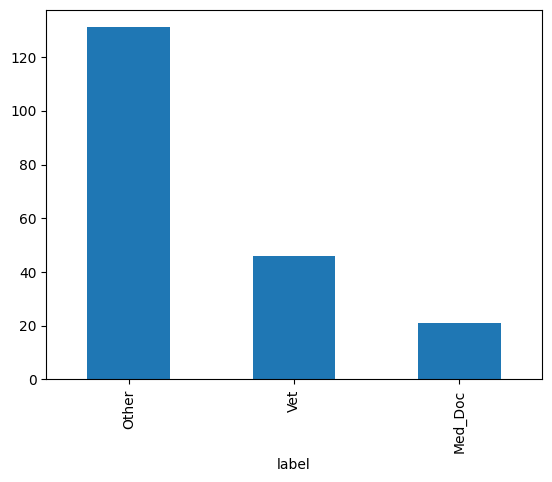

In [17]:
df.label.value_counts().plot(kind='bar');

In [18]:
# Function to clean comments
def clean_comments(comments):
    # Split comments by "|", strip whitespace, and remove duplicates
    cleaned_comments = comments.split('|')
    cleaned_comments = [comment.strip() for comment in cleaned_comments]
    cleaned_comments = list(set(cleaned_comments))
    # Remove empty strings
    cleaned_comments = [comment for comment in cleaned_comments if comment]
    # Join the cleaned comments
    return ' '.join(cleaned_comments)

# Apply the cleaning function to the comments column and save the result in a new column
df['comments'] = df['comments'].apply(clean_comments)

In [19]:
from nltk.stem import PorterStemmer

# Initialize the PorterStemmer
stemmer = PorterStemmer()

In [20]:

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /Users/honesty/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/honesty/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
from nltk.tokenize import word_tokenize

In [22]:

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Stemming
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

# Apply the preprocessing to the comments column
df['comments'] = df['comments'].apply(preprocess_text)


In [6]:
# feature and target
X = df['comments']
y = df['label'] 


In [7]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
df['label'].value_counts()

label
Other      131
Vet         46
Med_Doc     21
Name: count, dtype: int64

In [11]:
label_list = ['Other', 'Vet', 'Med_Doc']

In [8]:
doc2vec = Doc2Vec()
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled
X_train, X_test, y_train, y_test = train_test_split(df['comments'], df['label'], random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [9]:
all_data[:5]

[TaggedDocument(words=['https', 'wwwgovuk', 'skilledworkervisa', 'whenyoucanbepaidless', 'ive', 'learned', 'hasnt', 'really', 'taught', 'earlier', 'mutable', 'structures', 'blood', 'vessels', 'liver', 'heart', 'etc', 'need', 'compared', 'immutable', 'ones', 'primarily', 'bones', 'average', 'measurements', 'normal', 'heart', 'left', 'atrium', 'etc', 'wide', 'variety', 'breeds', 'individuals', 'makes', 'sense', 'compare', 'pulmonary', 'vessels', 'width', 'ribs', 'heart', 'size', 'vertebrae', 'obviously', 'isnt', 'one', 'size', 'fits', 'solution', 'either', 'definitely', 'help', 'deciding', 'whether', 'something', 'normal', 'abnormal', 'thus', 'guide', 'diagnosis', 'hematoma', 'develops', '25', 'weeks', 'surgery', 'wasnt', 'surgery', 'done', 'badly', 'like', 'actual', 'part', 'goes', 'inside', 'body', 'unless', 'youre', 'scrubbed', 'wearing', 'sterile', 'gloves', 'thats', 'definitely', 'break', 'asepsis', 'like', 'common', 'feeling', 'world', 'youre', 'starting', 'fact', 'feel', 'way', 'h

In [10]:
model_dbow = Doc2Vec(dm=0, vector_size=5, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

  0%|          | 0/198 [00:00<?, ?it/s]

100%|██████████| 198/198 [00:00<00:00, 3740865.73it/s]


In [11]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 5, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 5, 'Test')

/var/folders/4b/y66j_ccs6336dsqfhxjxlcqw0000gn/T/ipykernel_9320/4079924961.py:13: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vectors[i] = model.docvecs[prefix]


In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=label_list))

accuracy 0.65


NameError: name 'label_list' is not defined

In [15]:
from sklearn.linear_model import SGDClassifier


In [16]:
logreg = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=13, tol=None)
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=label_list))

accuracy 0.45


NameError: name 'label_list' is not defined